In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio
import mat73
import gseapy
from gseapy import barplot, dotplot
import glob
import polars as pl
import logomaker
from Bio.Seq import Seq
from Bio.pairwise2 import format_alignment
from Bio import pairwise2
from Bio import motifs
import os
from itertools import repeat
from collections import Counter
%config InlineBackend.figure_format='retina'
import matplotlib
import pickle

# This is needed for the Ilustrator for it to understand the fonts
matplotlib.rcParams['pdf.fonttype'] = 42

/home/labs/barkailab/vovam/miniconda/envs/mammalian/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [74]:
os.makedirs('Figures', exist_ok=True)

In [75]:
# Matrix of log2(DMSO/IAA) (that was easier for me because this way >0 means that gene was upregulated in presence of target TF)
expression = pd.read_csv('data/expression_log2fc.csv', index_col=0)

# Matrix of Sum of Read on Promoters per TF (SumProm)
chec = pd.read_csv('data/chec_sumprom.csv', index_col=0)

# Zscore normaliztion and num of targets extraction
zscored = (chec - chec.mean()) / chec.std()
zscored_bs = zscored.apply(lambda x: (x>=3.5).sum())

# Misc dataframes with gene/promter definitions and nucleotide sequences of promoters
prom_definitions = pd.read_csv('data/promoter_definitions.csv', index_col=0)
prom_sequences = pd.read_csv('data/promoter_sequences.csv', index_col=0)

# Data from Supp Table incicating number of targets per TF 
total_bs = pd.read_excel('data/41586_2025_8916_MOESM3_ESM.xlsx', sheet_name='table_S1a', index_col=0).loc[:, 'Total binding sites'].dropna().loc[chec.columns]

# Genes defined as Environmental Stress Reponse induced(stress) and repressed(ribosomal) from https://pmc.ncbi.nlm.nih.gov/articles/PMC15070/
with open ('data/misc/ribosomal_genes.txt', 'r') as f:
    ribo_genes = f.read().split('\n')
with open ('data/misc/stress_gens.txt', 'r') as f:
    stress_genes = f.read().split('\n')    

# Because there is no clear defintion on what pwms were used for motif analysis I compiled a list of TF->pwm by myself, to get 1 motif per 1 TF.
motifs_id = pd.read_csv('data/tf_cisbp_mot_map.csv', index_col=0)
mot_con = set(chec.columns).intersection(motifs_id.dropna().index)

# Loading the mnase-seq struct for the genomic tracks plots
with open('data/misc/nuc_struct.pkl', 'rb') as f:
    nucchr = pd.DataFrame(pickle.load(f))
    
# Load General genomic params
gp = pd.read_csv('data/geneinfo_params.csv', index_col=0)

# These are the functions used to plot the genomic tracks (not really important for the analysis)

In [76]:
def draw_arrow(ax, coords, hw, hl, wd, ya,s, text):
    """
    Draws a horizontal arrow with an annotation on a given axis, typically representing a gene or feature.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis object on which to draw the arrow.

    coords : tuple
        A tuple (start, stop) indicating the start and end coordinates of the arrow.

    hw : float
        Head width of the arrow.

    hl : float
        Head length of the arrow.

    wd : float
        Line width (thickness) of the arrow shaft.

    ya : float
        Vertical position (y-axis) to place the arrow.

    s : float
        Font size for the text label.

    text : str
        Label to annotate the arrow with (e.g., gene name).
    """
    start = coords[0]
    stop = coords[1]
    if (start-stop) > 0:
        ax.arrow(start, ya, -(start-stop)+hl,0, head_width=hw, head_length=hl, width=wd, fc='gainsboro', ec='black', lw=.5)
    else:
        ax.arrow(start, ya, (stop-start)-hl,0, head_width=hw, head_length=hl, width=wd, fc='gainsboro', ec='black', lw=.5)
    ax.text((min(start,stop)+np.abs(stop-start)/4), ya+10, text, size=s)

def draw_line(ax, coord, c='k', lw=.5, ls='--'):
    """
    Draws a vertical dashed line on the given axis at a specified x-coordinate.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis object on which to draw the line.

    coord : int or float
        The x-axis position where the vertical line should be placed.

    c : str, optional
        Line color (default is 'k' for black).

    lw : float, optional
        Line width (default is 0.5).

    ls : str, optional
        Line style (default is dashed).
    """
    ax.axvline(coord, c=c, lw=lw, ls=ls)
    
def draw_promoter(chrom, start_gene,lim_data, mean_data, nucchr=nucchr,  title='', save=False, gp=gp, verified=True):
    """
    Plots transcription factor binding profiles, MNase-seq signal, and gene models for a genomic region
    surrounding a given gene.

    Parameters
    ----------
    chrom : str or int
        Chromosome identifier (e.g., 'X' or 16).

    start_gene : int
        Start coordinate of the reference gene (center of the plotted region).

    lim_data : dict or pd.Series
        Dictionary of y-axis limits for each TF to cap the dynamic range of the tracks.

    mean_data : pd.DataFrame
        Matrix of mean signal tracks per transcription factor (rows = chromosomes, values = arrays).

    nucchr : pd.DataFrame, optional
        Matrix of MNase-seq profiles for each chromosome (default uses global `nucchr`).

    title : str, optional
        Title for the figure (unused in current version).

    save : str or bool, optional
        If a string (filename), the figure is saved to that path. If False, it is not saved.

    gp : pd.DataFrame, optional
        Gene annotation DataFrame with at least columns `chr_loc`, `start`, `stop`, and `status`.

    verified : bool, optional
        Whether to filter for 'Verified ORF' genes (default is True).

    Returns
    -------
    None
        Displays or saves a matplotlib figure with:
            - Arrows for genes in the region
            - TF binding tracks (mean signal)
            - Nucleosome profile track (MNase-seq)
            - A scale bar and coordinate annotation
    """
    
    # Define genomic window around the gene center
    startchr = start_gene - 6000
    stopchr = start_gene + 6000

    # Filter gene annotation table for genes within the window on the same chromosome
    # Clip ensures coordinates stay within plot range
    if verified:
        genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'")
                        .loc[:, ['start', 'stop']]
                        .applymap(int) - startchr).clip(0)
    else:
        genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr")
                        .loc[:, ['start', 'stop']]
                        .applymap(int) - startchr).clip(0)

    # Extract signal tracks (e.g. TFs) for the specified chromosome and window
    tracks = mean_data.loc[chrom].apply(lambda x: x[startchr:stopchr])

    # Create one axis per track + gene axis + MNase axis
    fig, ax = plt.subplots(tracks.shape[0]+2, 1, constrained_layout=False,
                           sharex=True, sharey=False, dpi=150, figsize=(5, 1.5))

    m_track = tracks.apply(max)  # Max signal per track
    colors = ['indigo', 'maroon', 'chocolate', 'darkgreen', 'navy', 'steelblue', 'pink', 'royalblue', 'olive']
    maxy = []  # Store max y-axis values used per TF

    # Plot each TF track
    for tfi, axi, colori in zip(mean_data.columns, ax[1:], colors):
        plot_vec = tracks.loc[tfi]
        axi.fill_between(np.arange(plot_vec.shape[0]), plot_vec, color=colori, lw=.8)
        sns.despine(ax=axi, top=True, right=True)
        axi.set_ylabel(tfi, size=6, rotation=0, labelpad=20)
        axi.yaxis.label.set_color(colori)
        axi.set_xlim([-10, stopchr-startchr])

        # Adjust y-axis based on signal magnitude or predefined limit
        if m_track.loc[tfi] > lim_data[tfi]:
            axi.set_ylim([-5, m_track.loc[tfi]])
            maxy.append(m_track.loc[tfi])
        else:
            axi.set_ylim([-5, lim_data[tfi]])
            maxy.append(lim_data[tfi])

        axi.set_yticklabels(axi.get_yticklabels(), size=5)
        axi.tick_params(bottom=False, left=False)

    # Set the gene track y-axis
    ax[0].set_ylim([0, 100])
    hw, hl, wd, ya, ts = 30, 50, 10, 50, 5  # Arrow style parameters

    # Draw gene arrows and vertical lines on each track
    for i in range(genecoords.shape[0]):
        text = genecoords.index[i]
        draw_arrow(ax[0], genecoords.values[i], hw, hl, wd, ya, ts, text)
        for axi in ax[1:]:
            draw_line(axi, genecoords.values[i][0])

    # Style the gene track
    ax[0].tick_params(bottom=False, left=False)
    ax[0].set_yticklabels('')
    sns.despine(ax=ax[0], top=True, right=True, bottom=True, left=True)

    # Plot MNase-seq signal at the bottom
    ax[-1].fill_between(range(stopchr-startchr), nucchr.loc[chrom].apply(lambda x: x[startchr:stopchr]).values[0],
                        color='gainsboro')
    ax[-1].set_yticklabels('')
    ax[-1].set_ylabel('MNase-seq', size=6, rotation=0, labelpad=20)
    ax[-1].set_xticklabels('')
    ax[-1].tick_params(bottom=False, left=False)
    sns.despine(ax=ax[-1], top=True, right=True, bottom=False)

    fig.subplots_adjust(hspace=0.2)

    # Draw a 500bp scale bar on the first TF axis
    y = maxy[0] * 0.7
    ax[1].plot([(stopchr-startchr)-1000, (stopchr-startchr)-500], [y, y], c='k')
    ax[1].text((stopchr-startchr)-1000, y+2, '500bp', size=7)

    # Add genomic coordinate label to bottom axis
    ax[-1].set_xlabel('Chr{} {}..{} ({}kb)'.format(chrom, startchr, stopchr, (stopchr-startchr)/1000), size=6)

    # Save figure if requested
    if save:
        fig.savefig(save)

## Background calculation for the motif analysis

In [77]:
a = Seq(''.join(prom_sequences.seq.values).upper())
seq_count = pd.DataFrame(Counter(a), index=['nuc']).T
total_bp = seq_count.sum().values[0]
a_t = (seq_count.loc[['A','T']].sum() / total_bp)/2
g_c = (seq_count.loc[['G','C']].sum() / total_bp)/2
prom_background = {'A':a_t.values[0], 'T':a_t.values[0], 'G':g_c.values[0], 'C':g_c.values[0]}

# Functions used for some parts of analyses

In [78]:
def parse_cisbp_motif(path):
    """
    Parses a motif file in PFM (Position Frequency Matrix) format from the CIS-BP database.

    Parameters
    ----------
    path : str
        Path to the motif file in CIS-BP format (pfm-four-columns).

    Returns
    -------
    Bio.motifs.Motif
        Parsed motif object containing PWM and associated methods.
    """
    with open(path, 'r') as f:
        a = motifs.read(f, fmt='pfm-four-columns')
    return a

def plot_proms_motifs_comp(tf, zscored, chec, total_bs, prom_background, z_thresh=3.5, save=False, analyze_only=False, motifs_id=motifs_id, sequences=prom_sequences):
    """
    Analyzes and plots the relationship between promoter signal intensity,
    motif abundance, and TF-specific binding scores across promoters.

    This function compares two criteria for defining transcription factor (TF) targets:
    - Signal-based peaks from CHEC-seq data (`chec`)
    - Z-score thresholding from normalized binding scores (`zscored`)

    It also calculates motif occurrences using the CIS-BP motif PWM and visualizes 
    these relationships alongside promoter strength, highlighting bound vs. unbound promoters.

    Parameters
    ----------
    tf : str
        Name of the transcription factor to analyze.

    zscored : pd.DataFrame
        Z-scored binding matrix; genes (rows) × TFs (columns).

    chec : pd.DataFrame
        CHEC-seq signal matrix; genes (rows) × TFs (columns), normalized to [0,1] by dividing the counts by max(counts).

    total_bs : pd.Series
        Number of peak calls per TF, used to set the peak threshold.

    prom_background : dict
        Background nucleotide frequencies for PWM threshold computation.

    z_thresh : float, optional
        Z-score threshold for defining 'bound' promoters (default is 3.5).

    save : str or bool, optional
        Path to save the plot. If False, plot is not saved (default is False).

    analyze_only : bool, optional
        If True, skips plotting and returns the annotated DataFrame (default is False).

    motifs_id : pd.DataFrame
        DataFrame mapping TF names to motif IDs for file lookup.

    Returns
    -------
    pd.DataFrame
        Annotated DataFrame including signal strength, motif count, binding label, 
        and optionally plotting percentiles and raw signal.
    """
    
    # Load PWM motif for the TF from CIS-BP
    t_mot = parse_cisbp_motif(os.path.join('data/pwms_all_motifs/', motifs_id.loc[tf].values[0] + '.txt'))
    
    # Ensure no infinite values in the PSSM (happens if columns have zeros)
    if (np.isinf(pd.DataFrame(t_mot.pssm)).sum().sum() > 0):
        t_mot.pseudocounts = 0.1  # Add pseudocount to stabilize

    # Extract z-scored TF binding profile and identify genes above threshold
    tfd = zscored.loc[:, tf]
    tind = tfd[(tfd >= z_thresh).values].index  # Genes defined as bound by z-score

    # Normalize CHEC signal for TF and sort promoters by increasing signal
    x = chec.loc[:, tf].sort_values()
    x = x / x.max()

    # Determine the promoter strength value corresponding to z-score threshold
    z_thresh = x.loc[tind].min()

    # Determine signal threshold corresponding to top N binding sites (peak-based)
    h_thresh = x.iloc[-int(total_bs.loc[tf]):].min()

    # Compute motif occurrence threshold using balanced PWM score
    dist = t_mot.pssm.distribution(background=prom_background)
    threshold = dist.threshold_balanced(1000)

    # Count the number of motif matches (forward + reverse strand) above threshold per promoter
    mot_calc = sequences.loc[x[::-1].index, 'seq'].apply(
        lambda x: np.sum(t_mot.reverse_complement().pssm.calculate(x) >= threshold)
                + np.sum(t_mot.pssm.calculate(x) >= threshold)
    )

    # If only analysis is requested, prepare annotated DataFrame and return
    for_plot = pd.DataFrame(x[::-1])
    for_plot = pd.concat([for_plot, mot_calc], axis=1)
    for_plot.loc[tind, 'targets'] = 'z-score'
    for_plot.iloc[len(tind):int(total_bs.loc[tf])].loc[:, 'targets'] = 'peaks'
    for_plot.targets = for_plot.targets.fillna('not bound')
    for_plot.columns = ['signal', 'mot_n', 'targets']

    # Add original CHEC signal as 'sumprom'
    for_plot.loc[:, 'sumprom'] = chec.loc[:, tf].sort_values().values

    # Rename columns with 'perc' placeholder for compatibility
    for_plot.columns = ['signal', 'mot_n', 'targets', 'sumprom']
    if analyze_only:
 
        return for_plot

    # ---------- Plotting Section ----------
    fig, ax = plt.subplots(1, figsize=(10, 1), dpi=300, constrained_layout=True)

    # Set color scale max value for motif counts
    vmax = mot_calc.loc[tind].median()  # Optionally adjusted later
    vmax = 3  # Manually fixed

    # Scatter plot of promoter strength vs motif count
    s = ax.scatter(
        x, np.zeros(chec.shape[0]), s=100, c=mot_calc[::-1],
        zorder=20, vmax=vmax, cmap='Reds', rasterized=True, linewidths=0
    )

    # Add colorbar and vertical lines for thresholds
    fig.colorbar(s, label='Mot number')
    ax.set_ylim([-0.22, 0.22])
    ax.axvline(h_thresh, c='red', zorder=20)   # Peak threshold
    ax.axvline(z_thresh, c='green')            # Z-score threshold

    # Annotate the number of peaks and z-score targets
    ax.text(h_thresh + (z_thresh - h_thresh)/2, .3, int(total_bs.loc[tf]))
    ax.text(z_thresh + (x.max() - z_thresh)/2, .3, len(tind))

    ax.axhline(0, c='k', lw=.5)  # Center line

    # Style axis
    ax.set_yticklabels('')
    ax.set_xlabel('Promoter Strength')
    ax.tick_params(axis='y', length=0)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    sns.despine(ax=ax, right=True, top=True, left=True)
    ax.set_ylabel(tf)

    # Inset: Motif logo
    axin1 = ax.inset_axes([-0.2, 0.4, 0.1, 0.45])
    logomaker.Logo(pd.DataFrame(t_mot.pssm), ax=axin1)
    axin1.set_ylim([0, 2])
    axin1.set_xticklabels('')
    axin1.set_yticklabels('')
    axin1.tick_params(axis='y', length=0)
    axin1.tick_params(axis='x', length=0)
    sns.despine(ax=axin1, top=True, left=True, bottom=True)

    # Save figure if requested
    if save:
        fig.savefig(save)

    return for_plot

## 1A

/tmp/ipykernel_2185165/185893714.py:102: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_plot.iloc[len(tind):int(total_bs.loc[tf])].loc[:, 'targets'] = 'peaks'


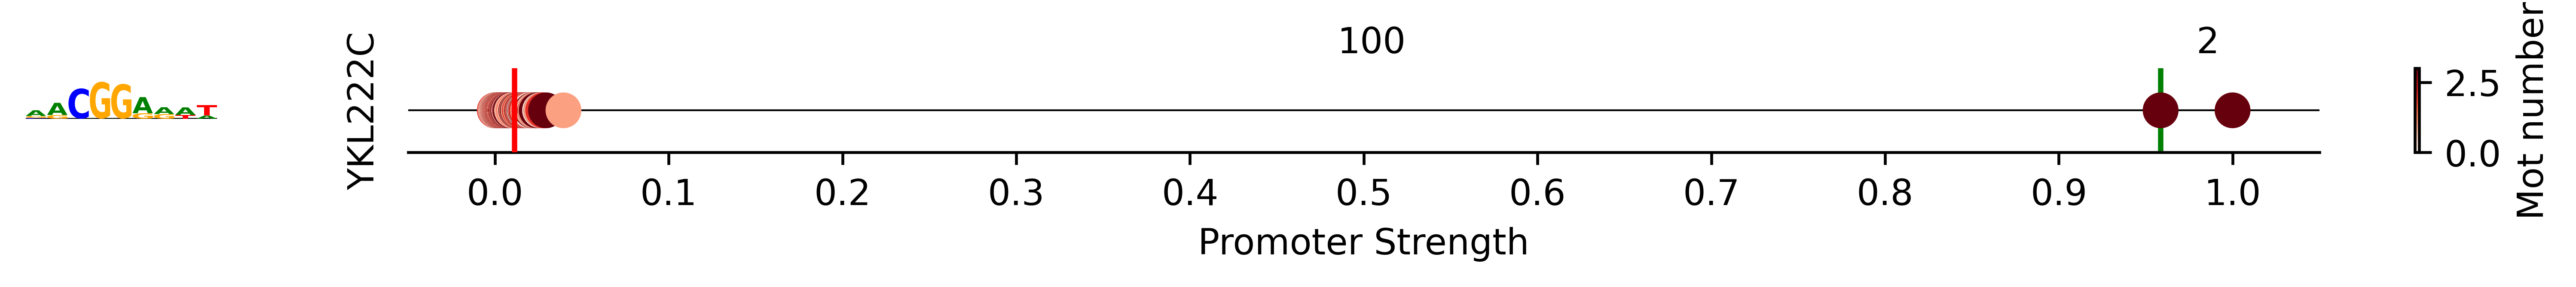

In [79]:
_ = plot_proms_motifs_comp('YKL222C', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures/ykl222c.pdf')

/tmp/ipykernel_2185165/185893714.py:102: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_plot.iloc[len(tind):int(total_bs.loc[tf])].loc[:, 'targets'] = 'peaks'


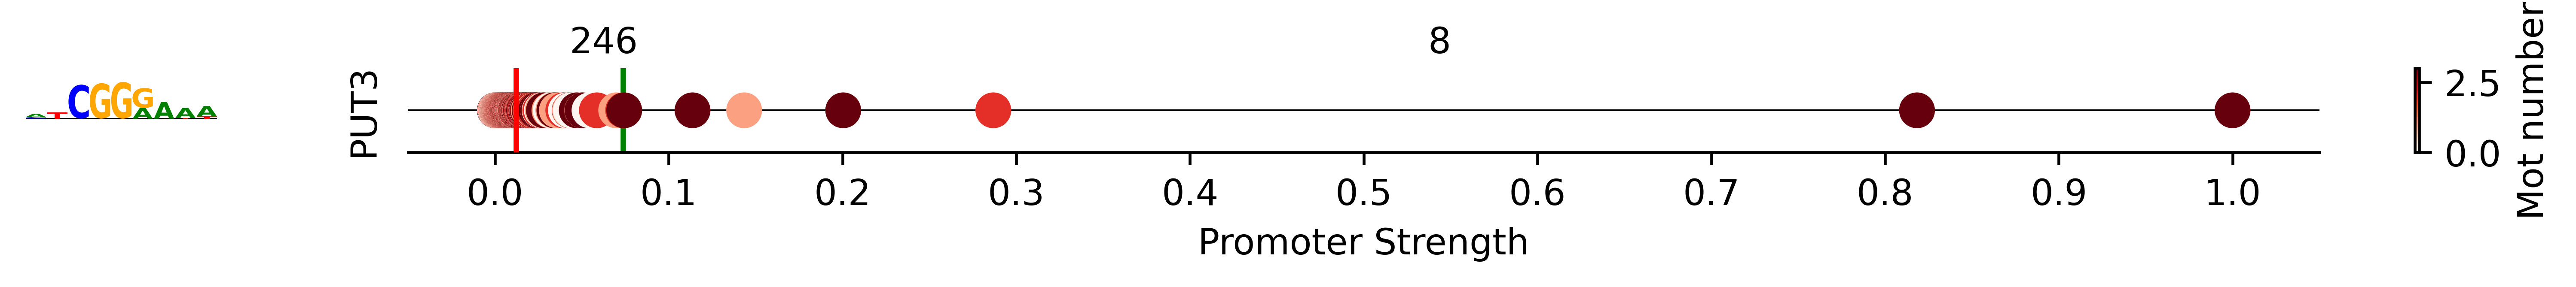

In [80]:
_ = plot_proms_motifs_comp('PUT3', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures/put3.pdf')

/tmp/ipykernel_2185165/185893714.py:102: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_plot.iloc[len(tind):int(total_bs.loc[tf])].loc[:, 'targets'] = 'peaks'


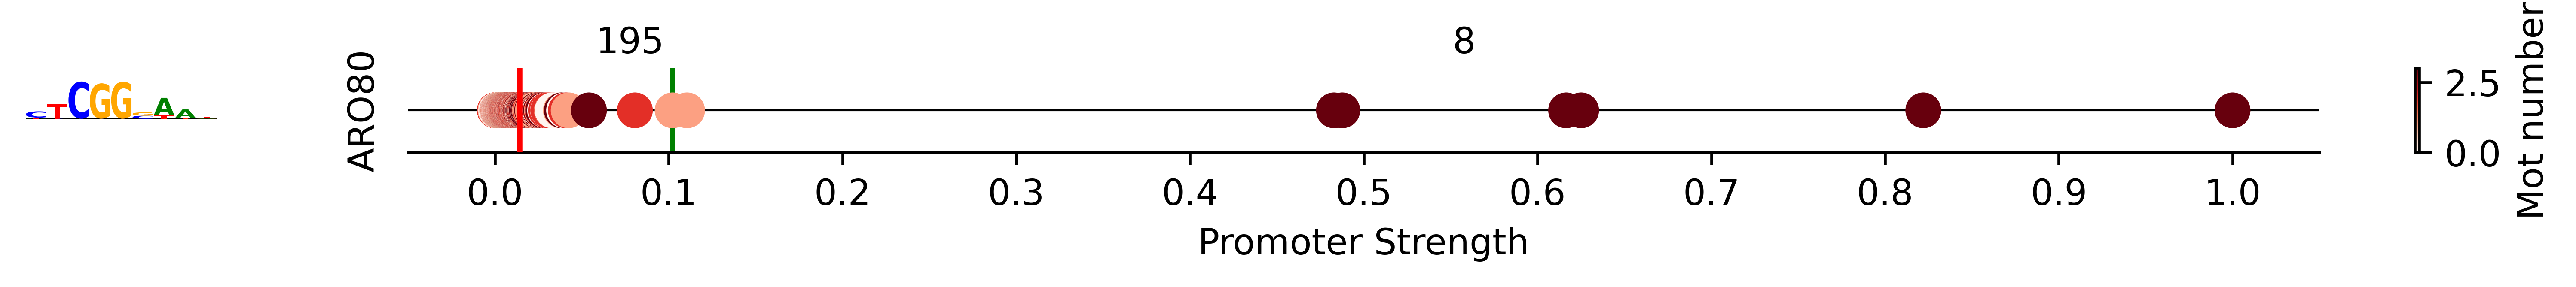

In [81]:
_ = plot_proms_motifs_comp('ARO80', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures/aro80.pdf')

/tmp/ipykernel_2185165/185893714.py:102: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_plot.iloc[len(tind):int(total_bs.loc[tf])].loc[:, 'targets'] = 'peaks'


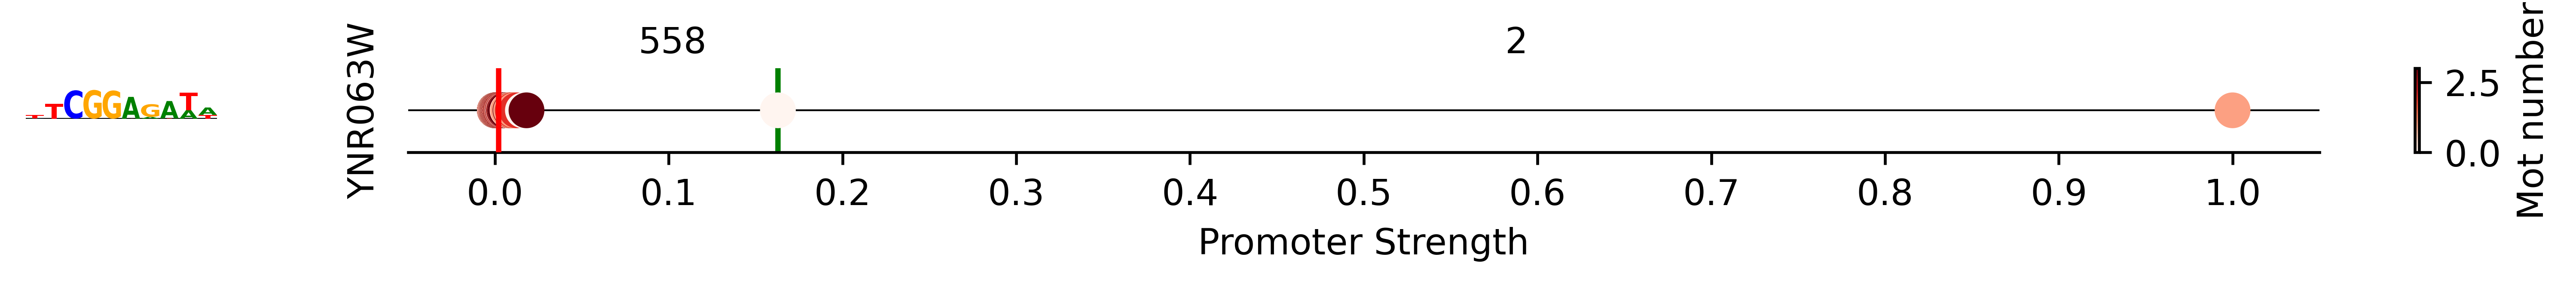

In [82]:
_ = plot_proms_motifs_comp('YNR063W', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures/YNR063W.pdf')

/tmp/ipykernel_2185165/185893714.py:102: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_plot.iloc[len(tind):int(total_bs.loc[tf])].loc[:, 'targets'] = 'peaks'


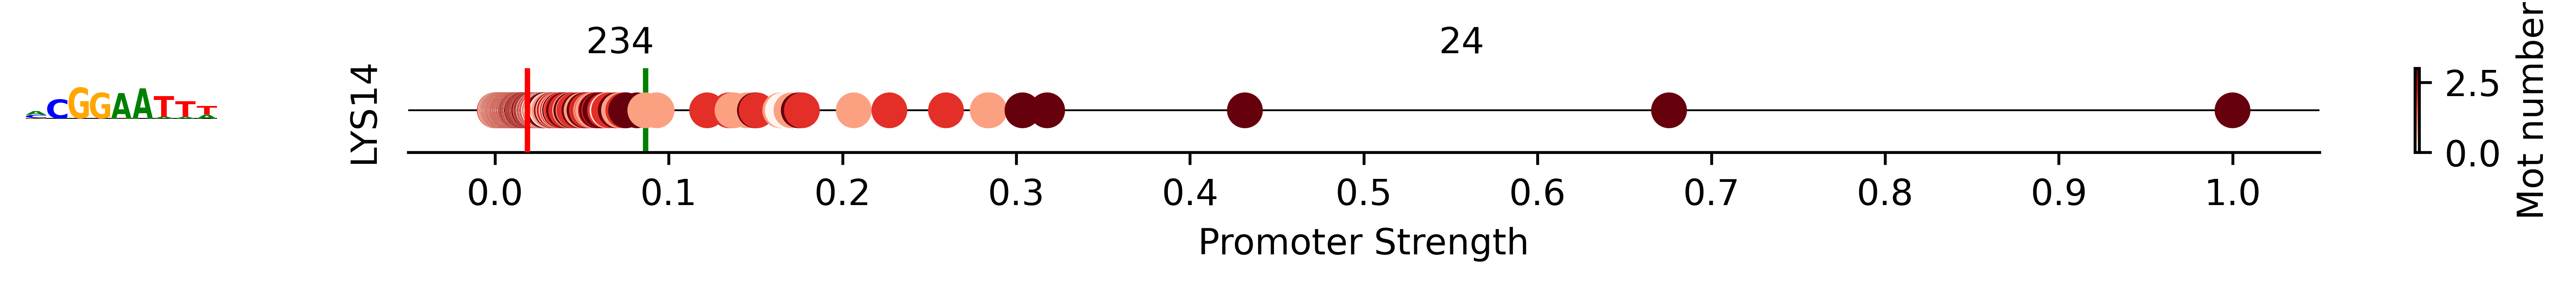

In [83]:
_ = plot_proms_motifs_comp('LYS14', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures/lys14.pdf')

/tmp/ipykernel_2185165/185893714.py:102: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_plot.iloc[len(tind):int(total_bs.loc[tf])].loc[:, 'targets'] = 'peaks'


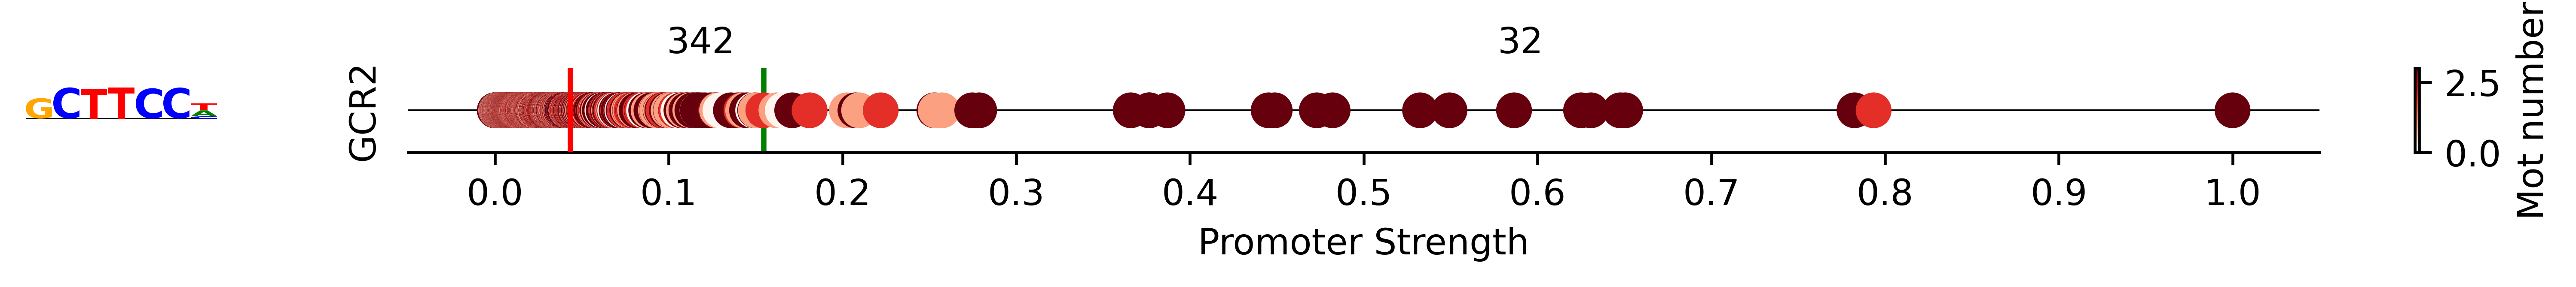

In [85]:
_ = plot_proms_motifs_comp('GCR2', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures/gcr2.pdf')

/tmp/ipykernel_2185165/185893714.py:102: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_plot.iloc[len(tind):int(total_bs.loc[tf])].loc[:, 'targets'] = 'peaks'


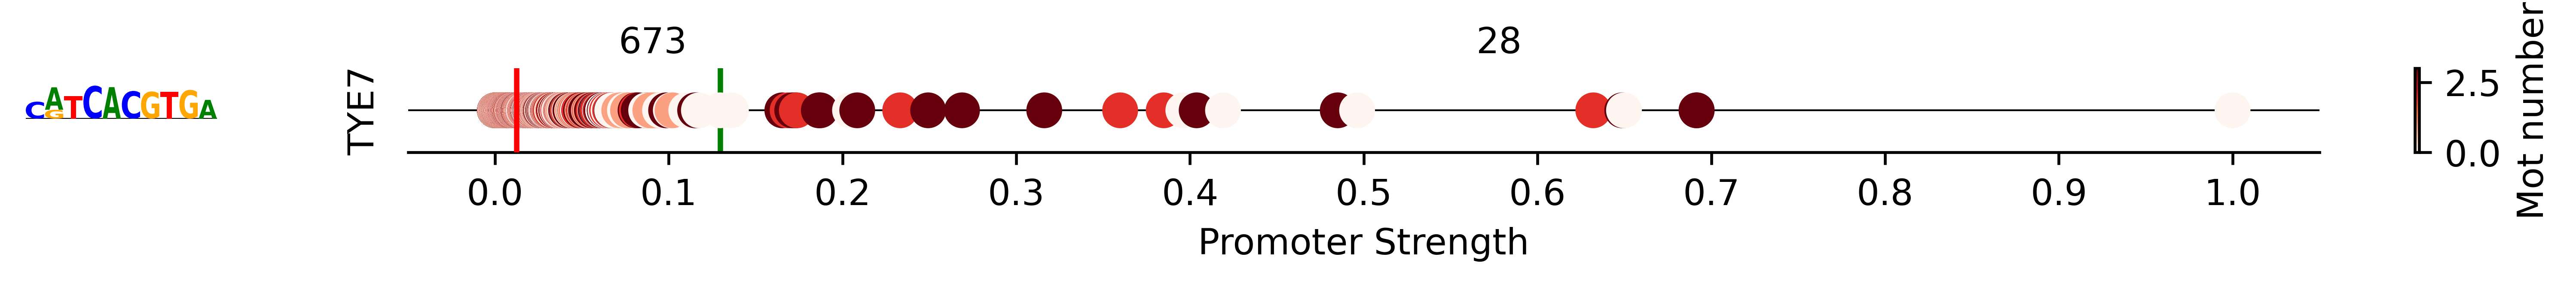

In [86]:
_ = plot_proms_motifs_comp('TYE7', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures/tye7.pdf')

/tmp/ipykernel_2185165/185893714.py:102: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_plot.iloc[len(tind):int(total_bs.loc[tf])].loc[:, 'targets'] = 'peaks'


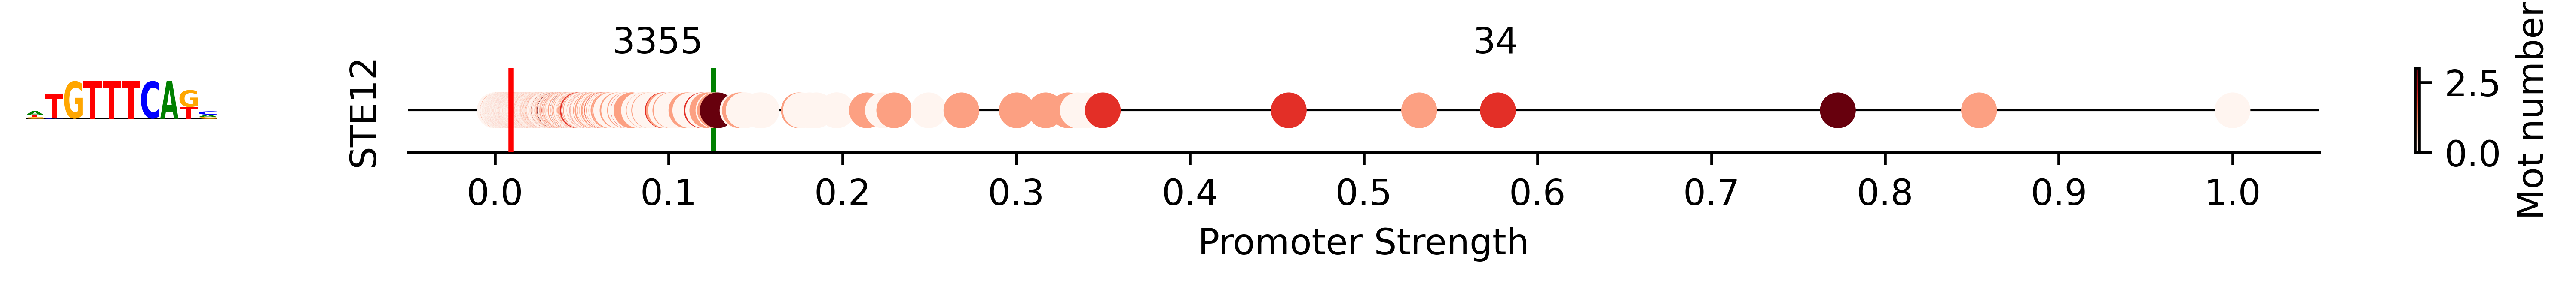

In [87]:
ste12_data = plot_proms_motifs_comp('STE12', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures/ste.pdf')

## 1C

In [88]:
def wrap_track_func(tf, prom_of_intrst, spath, gp=gp, verified=False):
    nnorm = pd.read_parquet(f'data/norm_files/norm_{tf}.gz')
    tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
    a,b = prom_definitions.set_index('name').loc[prom_of_intrst, ['chr_loc', 'start']].values.astype(int)
    draw_promoter(a,b,tracks_maxes, mean_data=nnorm,  title='', save=spath, gp=gp, verified=verified)

/tmp/ipykernel_2185165/3234153745.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
/tmp/ipykernel_2185165/3615634920.py:119: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(int) - startchr).clip(0)
/tmp/ipykernel_2185165/3615634920.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_2185165/3234153745.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
/tmp/ipykernel_2185165/3615634920.py:119: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(int) - startchr).clip(0)
/tmp/ipykernel_2185165/3615634920.py:149: UserWarning: se

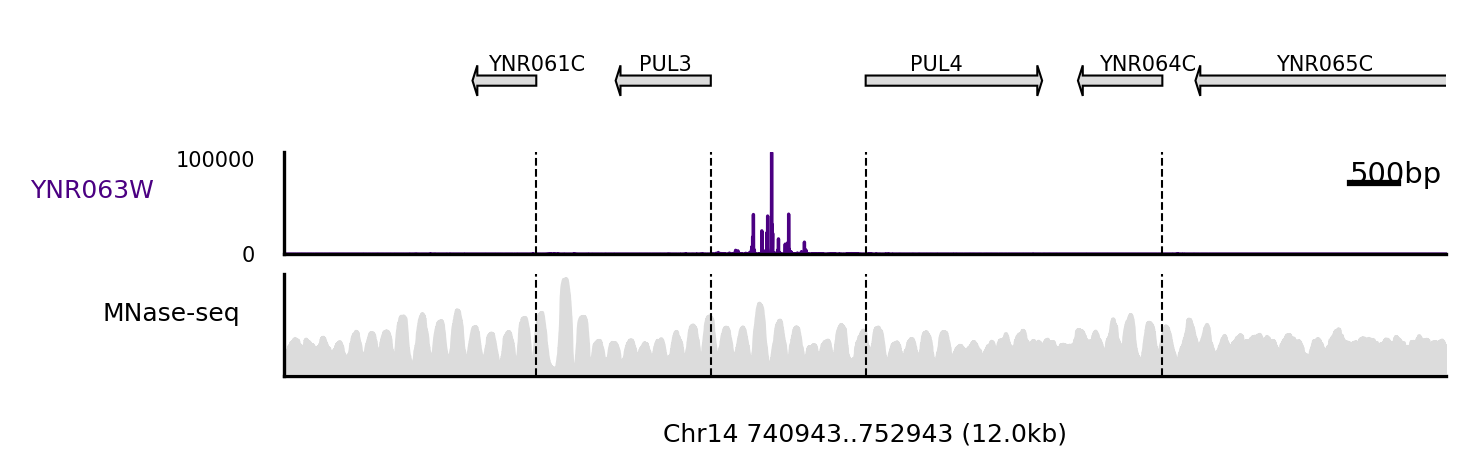

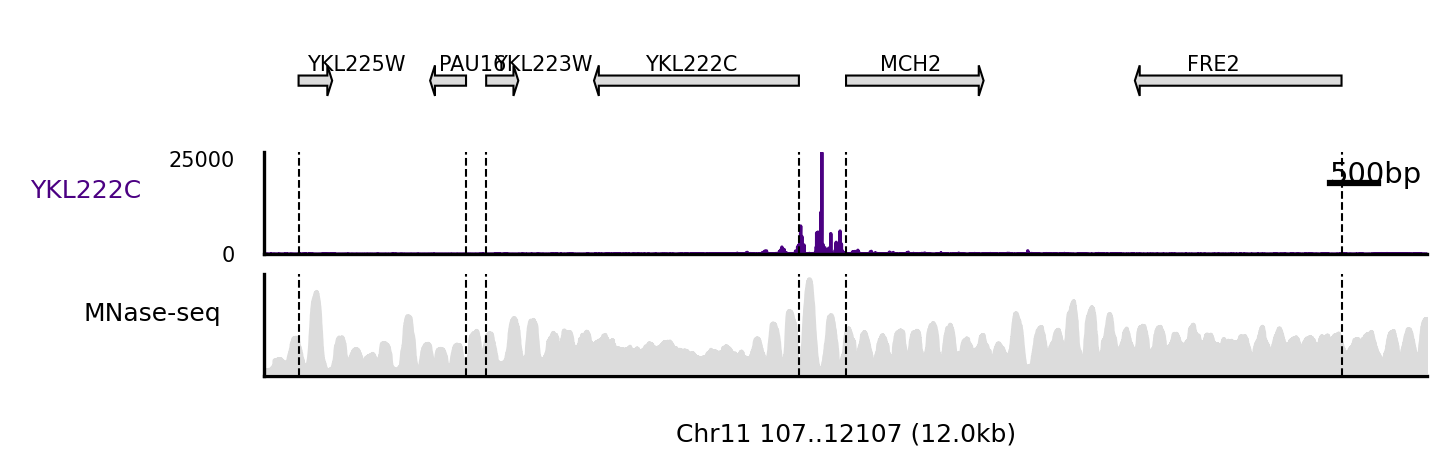

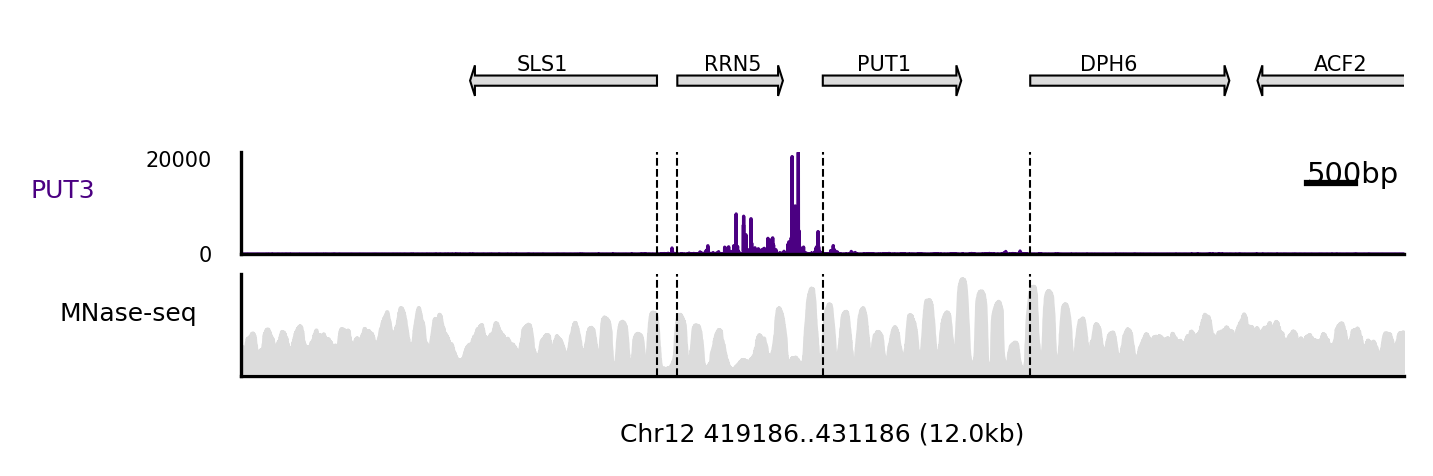

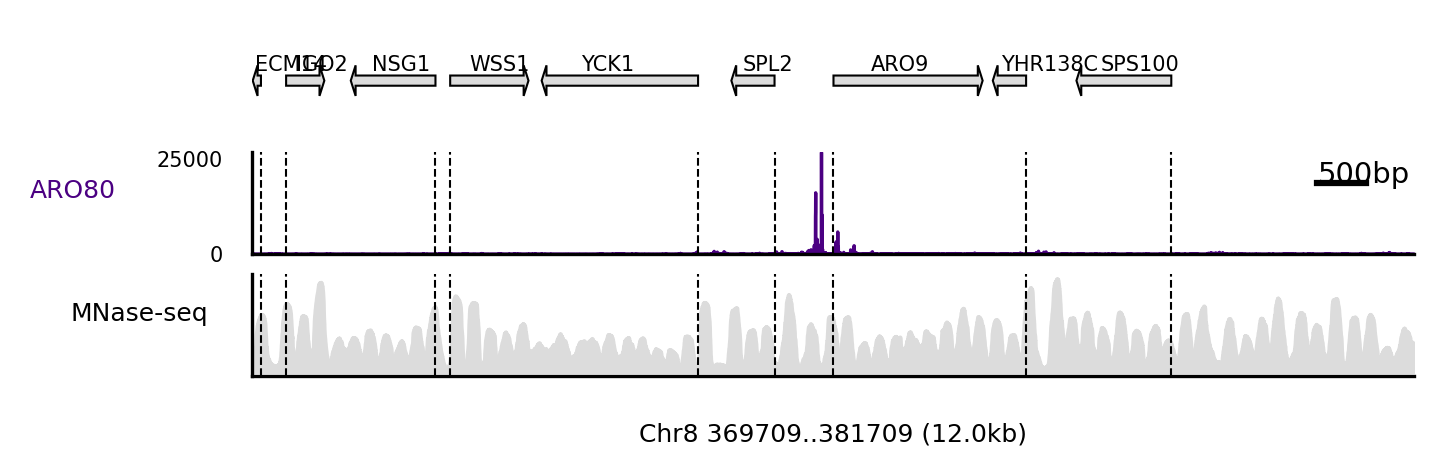

In [89]:
tf='YNR063W'
poi = 'YNR063W'
savep='Figures/PUL4_track.pdf'
wrap_track_func(tf, poi, savep)

tf='YKL222C'
poi = 'MCH2'
savep='Figures/YKL222C_track.pdf'
wrap_track_func(tf, poi, savep)

tf='PUT3'
poi = 'PUT1'
savep='Figures/PUT1_track.pdf'
wrap_track_func(tf, poi, savep, verified=True)

tf='ARO80'
poi = 'ARO9'
savep='Figures/ARO80_track.pdf'
wrap_track_func(tf, poi, savep, verified=True)

## 1D

### The data for the following analysis was taken from here - https://pubmed.ncbi.nlm.nih.gov/10657304/

In [90]:
alpha = pd.read_csv('data/alpha_factor_data/2010.alpha_conc.pcl', delimiter='\t', index_col=0).drop('EWEIGHT').drop('GWEIGHT', axis=1)
alpha_genes = pd.Index(gp.reset_index().reset_index().set_index('orf').loc[alpha.index.drop(['YBL100W-A', 'YBL100W-B'])].loc[:, 'index'])
alpha_for_ste12 = prom_definitions.loc[sorted(list(set(prom_definitions.index).intersection(alpha_genes)))].loc[:, 'name'].values
alpha = alpha.loc[gp.reset_index().loc[prom_definitions.loc[sorted(list(set(prom_definitions.index).intersection(alpha_genes)))].index].loc[:, 'orf']]
alpha = alpha[~alpha.index.duplicated(keep='first')]

alpha.index = prom_definitions.loc[sorted(list(set(prom_definitions.index).intersection(alpha_genes)))].loc[:, 'name']

/tmp/ipykernel_2185165/673927072.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


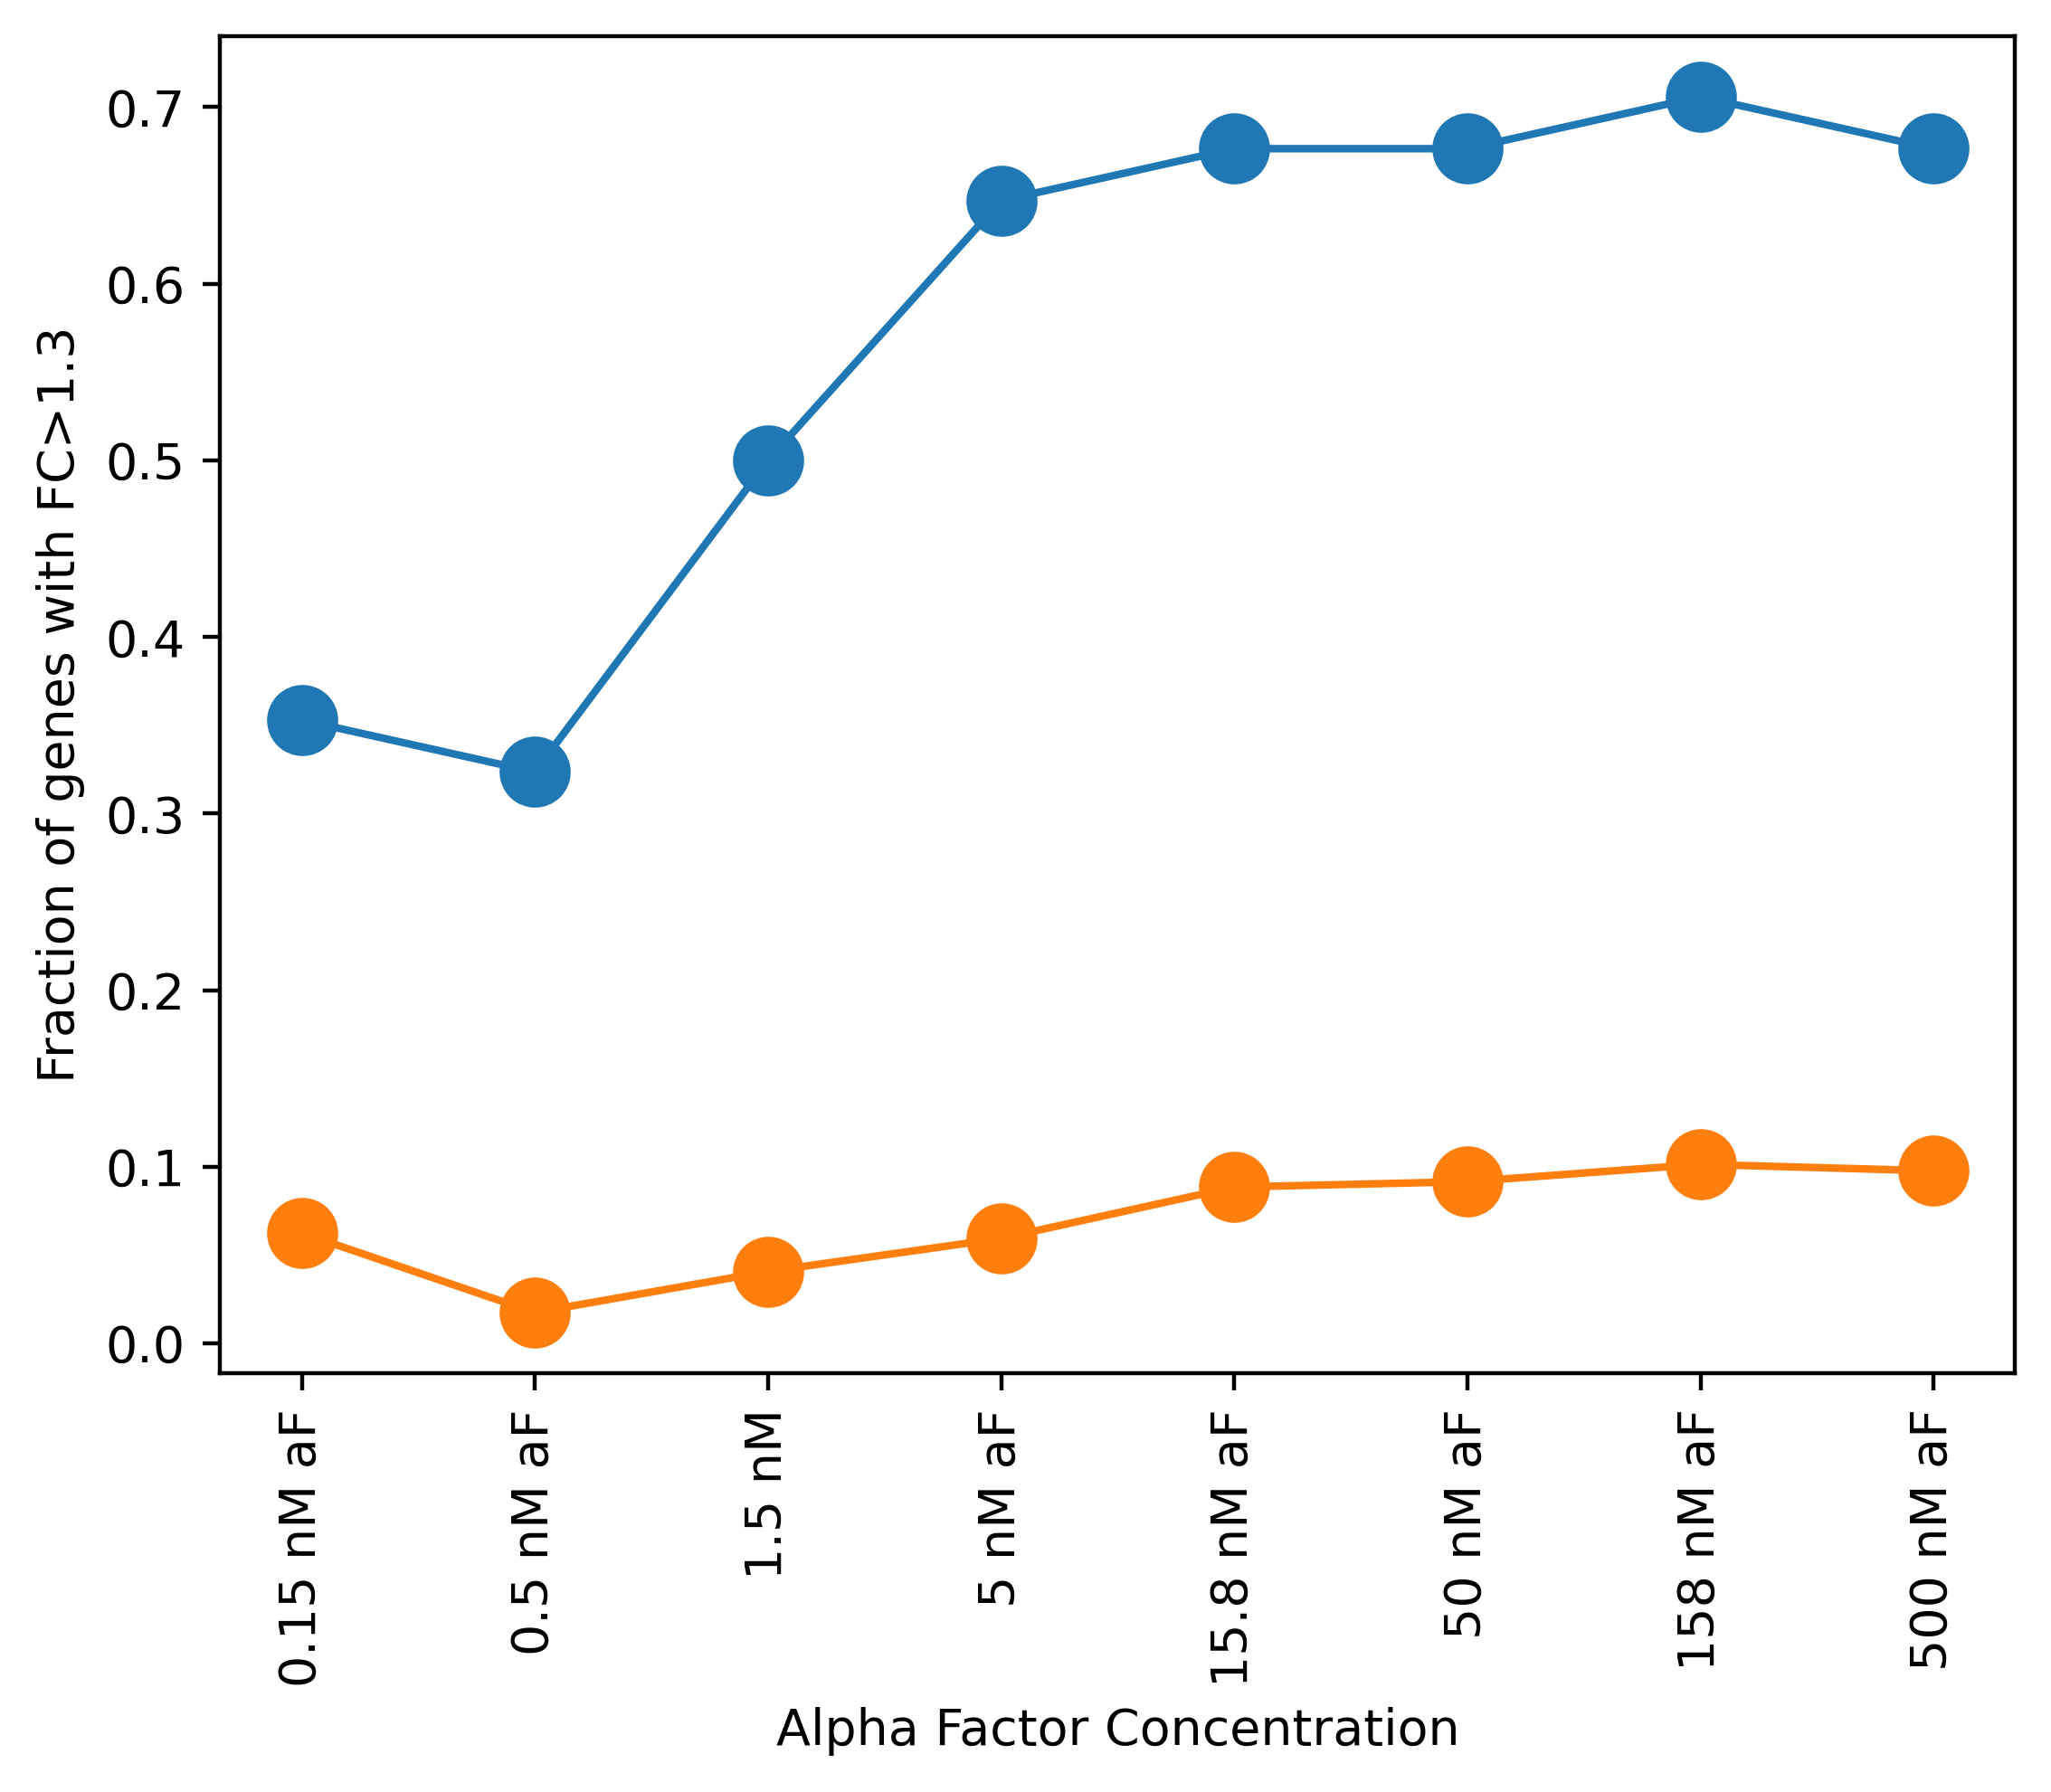

In [91]:
for_comp = ste12_data.loc[alpha.index].sort_values(by='sumprom', ascending=False)
fig, ax = plt.subplots(1, dpi=200)

us_fracs = ((alpha.loc[for_comp.query("targets=='z-score'").index].drop("NAME", axis=1)>np.log2(1.3)).sum() / for_comp.query("targets=='z-score'").index.shape[0])
ax.plot(us_fracs.index, us_fracs)
ax.scatter(us_fracs.index, us_fracs, label='z-score',s=200, lw=0)

them_fracs = ((alpha.loc[for_comp.query("targets=='peaks'").index].drop("NAME", axis=1)>np.log2(1.3)).sum() / for_comp.query("targets=='peaks'").index.shape[0])
ax.plot(them_fracs.index, them_fracs)
ax.scatter(them_fracs.index, them_fracs, label='other targets',s=200, lw=0)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Alpha Factor Concentration')
ax.set_ylabel("Fraction of genes with FC>1.3")
fig.savefig("Figures/STE12_alpha_response.pdf")

## 1E + F

### Here is the code used to mine the SGD for known interactors I already have saved preprocessed version that i load but feel free to rerun it

In [92]:
# td = dict()
# for tf in chec.columns:
#     def get_interactor(row, tf=tf):
#         values = [row['locus1'], row['locus2']]
#         for val in values:
#             if val != tf:
#                 return val
#         return None  # fallback if neither value qualifies

#     url = f"https://www.yeastgenome.org/backend/locus/{tf}/regulation_details"

#     # Send GET request
#     response = requests.get(url)

#     # Check if request was successful
#     if response.status_code == 200:
#         data = pd.DataFrame(response.json())  # Parse JSON response
#     data = data.applymap(lambda x : x['display_name'] if isinstance(x, dict) else x)
#     data.loc[:, 'interactor'] = data.loc[:, ['locus1', 'locus2']].apply(get_interactor, axis=1)
#     data = data.drop(['id', 'locus1', 'locus2'], axis=1).set_index('interactor')
#     data = data.query("regulation_of == 'transcription'")
#     prob = list(set(data.index).difference(chec.index))
#     to_add = []
#     for i in prob:
#         if i:
#             if i in gp.reset_index().loc[:, 'name'].values:
#                 # print(f"Name {i}")
#                 ind = gp.reset_index().query("name==@i").index[0]
#                 if ind in df_for_sp.index:
#                     to_add.append(df_for_sp.loc[ind, 'name'])
#             elif i in gp.reset_index().loc[:, 'orf'].values:
#                 ind = gp.reset_index().query("orf==@i").index[0]
#                 if ind in df_for_sp.index:
#                     to_add.append(df_for_sp.loc[ind, 'name'])
#                 # print(f"ORF {i}")

#     nt = list(data.index.drop(prob))
#     nt.extend(to_add)
    
#     td[tf] = nt
# pd.DataFrame({key:pd.Series(value) for key, value in td.items()}).to_parquet('regulators_df.parquet')

In [93]:
reg_df = pd.read_parquet('data/regulators_df.parquet').T
reg_tf_dict = dict()
for i in reg_df.index:
    reg_ts = pd.Index(reg_df.loc[i].dropna().values).drop_duplicates()
    zts = zscored[zscored.loc[:, i]>=3.5].index
    zint = len(set(zts).intersection(reg_ts))
    if zint > 0:
        frac_z =  zint / zts.shape[0]
    else:
        frac_z = 0
    pts = chec.loc[:, i].sort_values(ascending=False).iloc[len(zts):int(total_bs.loc[i])].index
    pint = len(set(pts).intersection(reg_ts))
    if pint > 0 :
        frac_p = pint / pts.shape[0] 
    else:
        frac_p = 0
    

    reg_tf_dict[i] = {'zscore_frac':frac_z, 'peak_frac':frac_p, 'total_regs':reg_ts.shape[0],  }
reg_tf_df = pd.DataFrame(reg_tf_dict)


### And here is the code to extract the mot fracions from the data

In [94]:
# for i,tf in enumerate(mot_con):
#     if i % 25 == 0:
#         print(f"{i}/{len(mot_con)}")
#     ndf = plot_proms_motifs_comp(tf, zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save=False, analyze_only=True)
#     ndf.to_parquet(f'mot_calc_dfs/{tf}_calc_df.parquet')
    

In [95]:
mot_df_list = sorted(glob.glob('data/mot_calc_dfs/*_calc_df.parquet'))
resd = dict()
for i in mot_df_list:

    k = pd.read_parquet(i).loc[:, ['mot_n', 'targets']]
    k.mot_n = k.mot_n>0
    z = k.query("targets=='z-score'")
    frac_z = z.mot_n.sum() / z.shape[0]

    p = k.query("targets=='peaks'")
    frac_p = p.mot_n.sum() / p.shape[0]
    resd[i] = (frac_z, frac_p)

/tmp/ipykernel_2185165/1001750371.py:11: RuntimeWarning: invalid value encountered in scalar divide
  frac_p = p.mot_n.sum() / p.shape[0]
/tmp/ipykernel_2185165/1001750371.py:11: RuntimeWarning: invalid value encountered in scalar divide
  frac_p = p.mot_n.sum() / p.shape[0]


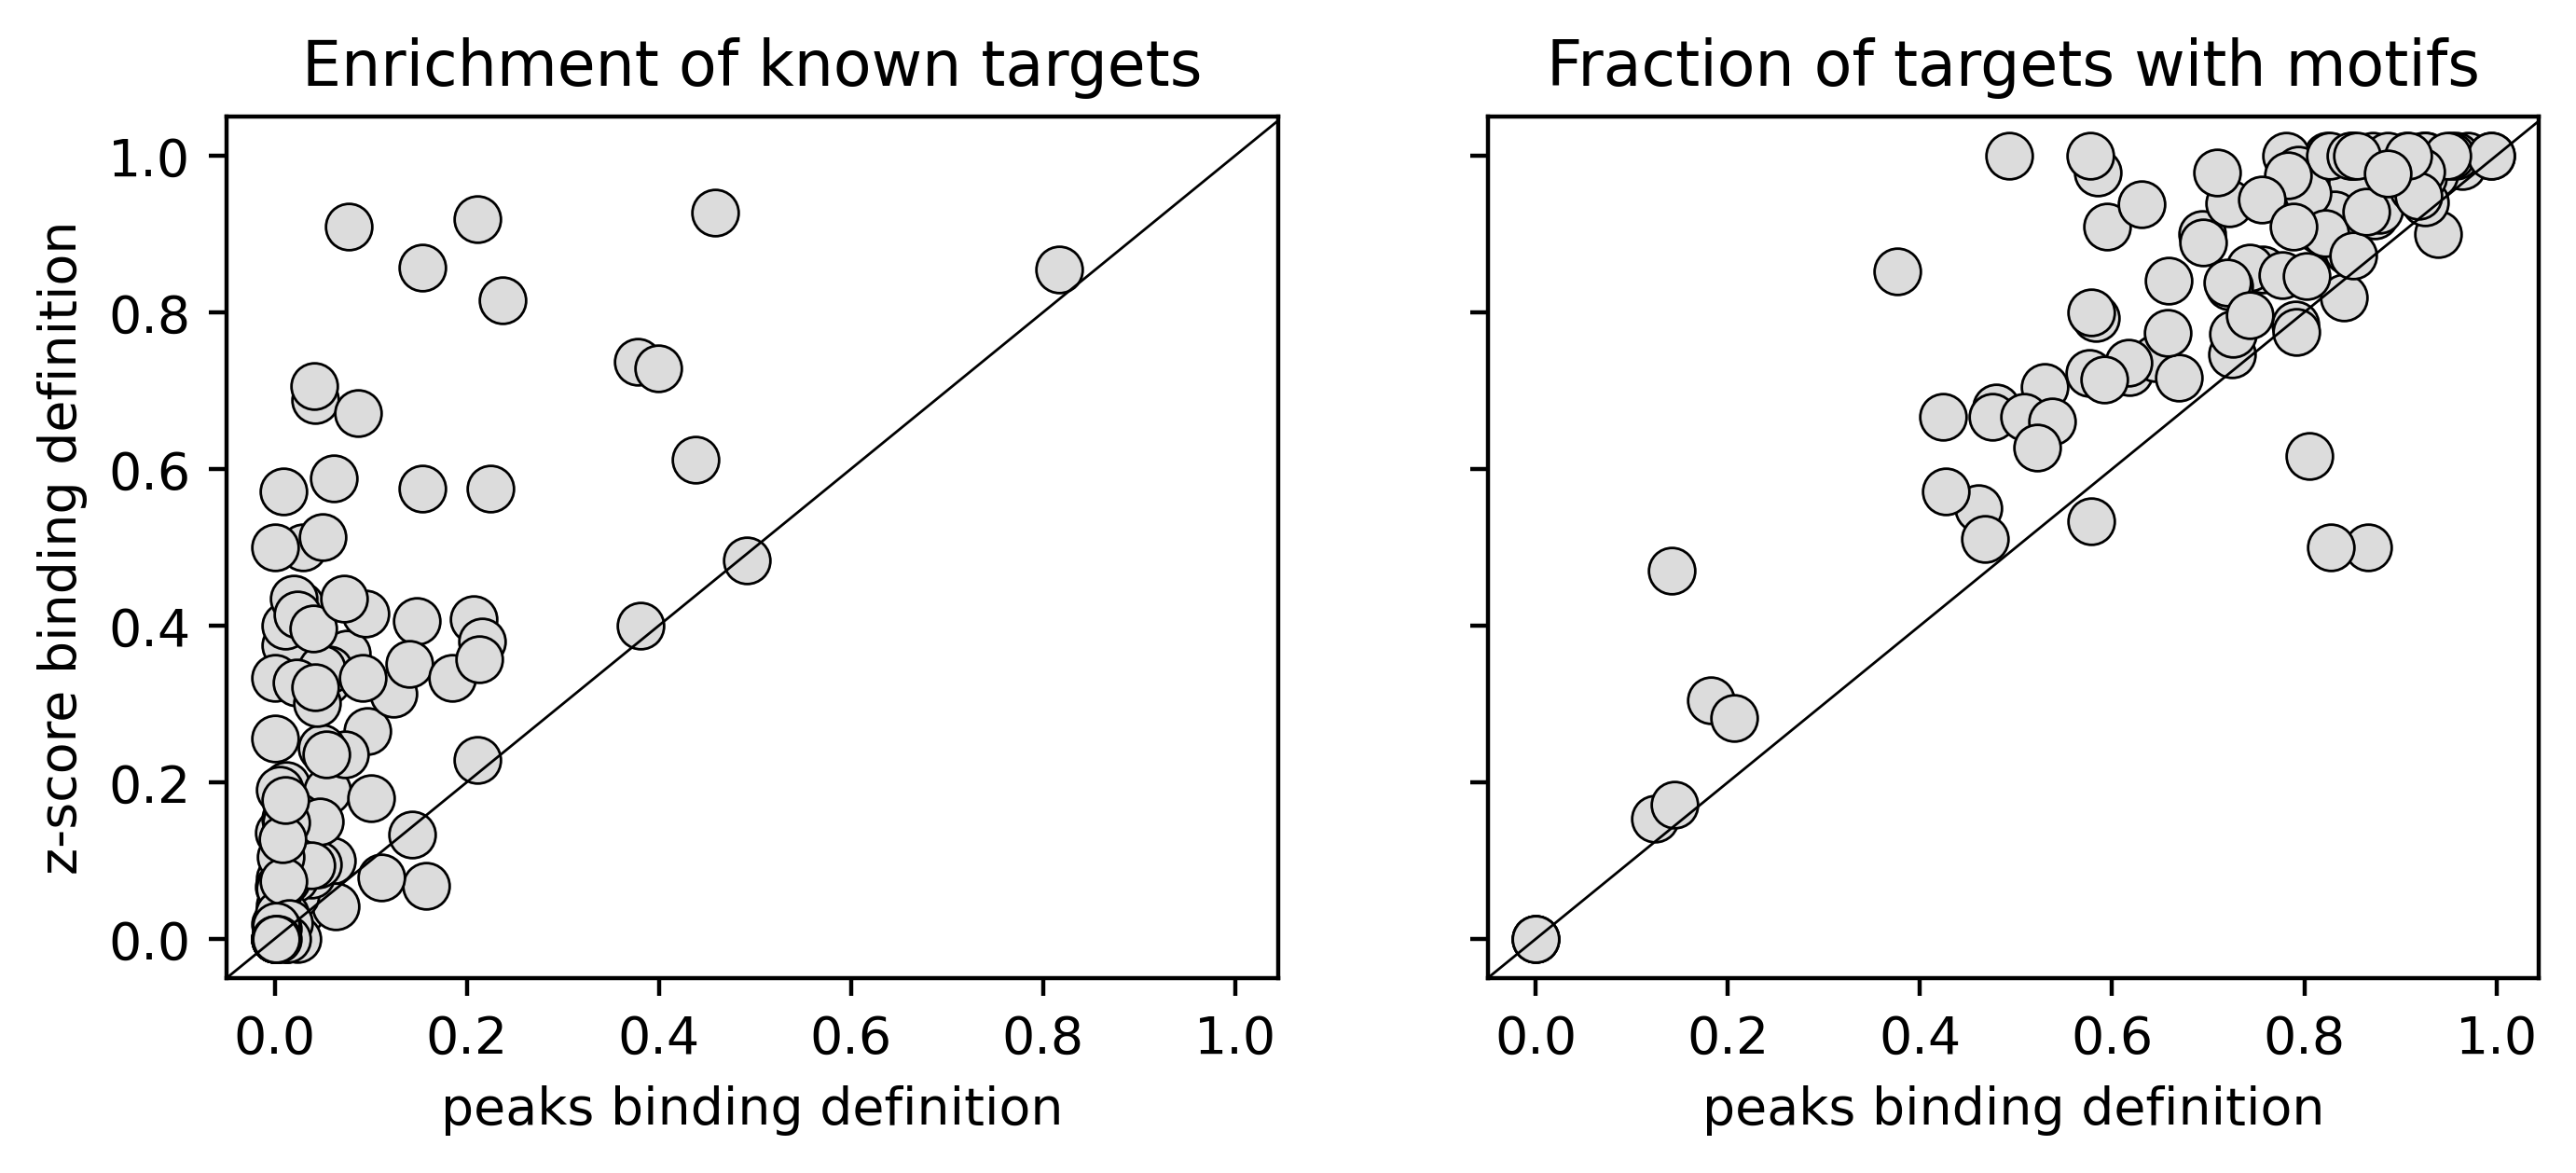

In [96]:

fig, (ax,ax1) = plt.subplots(1,2, figsize=(8,3), dpi=200, sharex=True, sharey=True)
ax.scatter(reg_tf_df.T.peak_frac, reg_tf_df.T.zscore_frac, c='gainsboro', ec='k', lw=.5, s=80)
ax.axline((0,0), slope=1, c='k', lw=.5)
ax.set_title('Enrichment of known targets')

ax.set_ylabel('z-score binding definition')
ax.set_xlabel('peaks binding definition')


ax1.scatter(pd.DataFrame(resd).T.iloc[:, 1], pd.DataFrame(resd).T.iloc[:, 0], c='gainsboro', ec='k', lw=.5, s=80)
ax1.axline((0,0), slope=1, c='k', lw=.5)
ax1.set_title("Fraction of targets with motifs")
# ax1.set_ylabel('z-score binding definition')
ax1.set_xlabel('peaks binding definition')

fig.savefig('Figures/Knwon_interactors_and_motifs_frac.pdf')

## 1G

### As I explained in README of the repo, and also in the email I used abs(log2(FC))>=1.3 as a threshold for functional targets

/tmp/ipykernel_2185165/3138016630.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


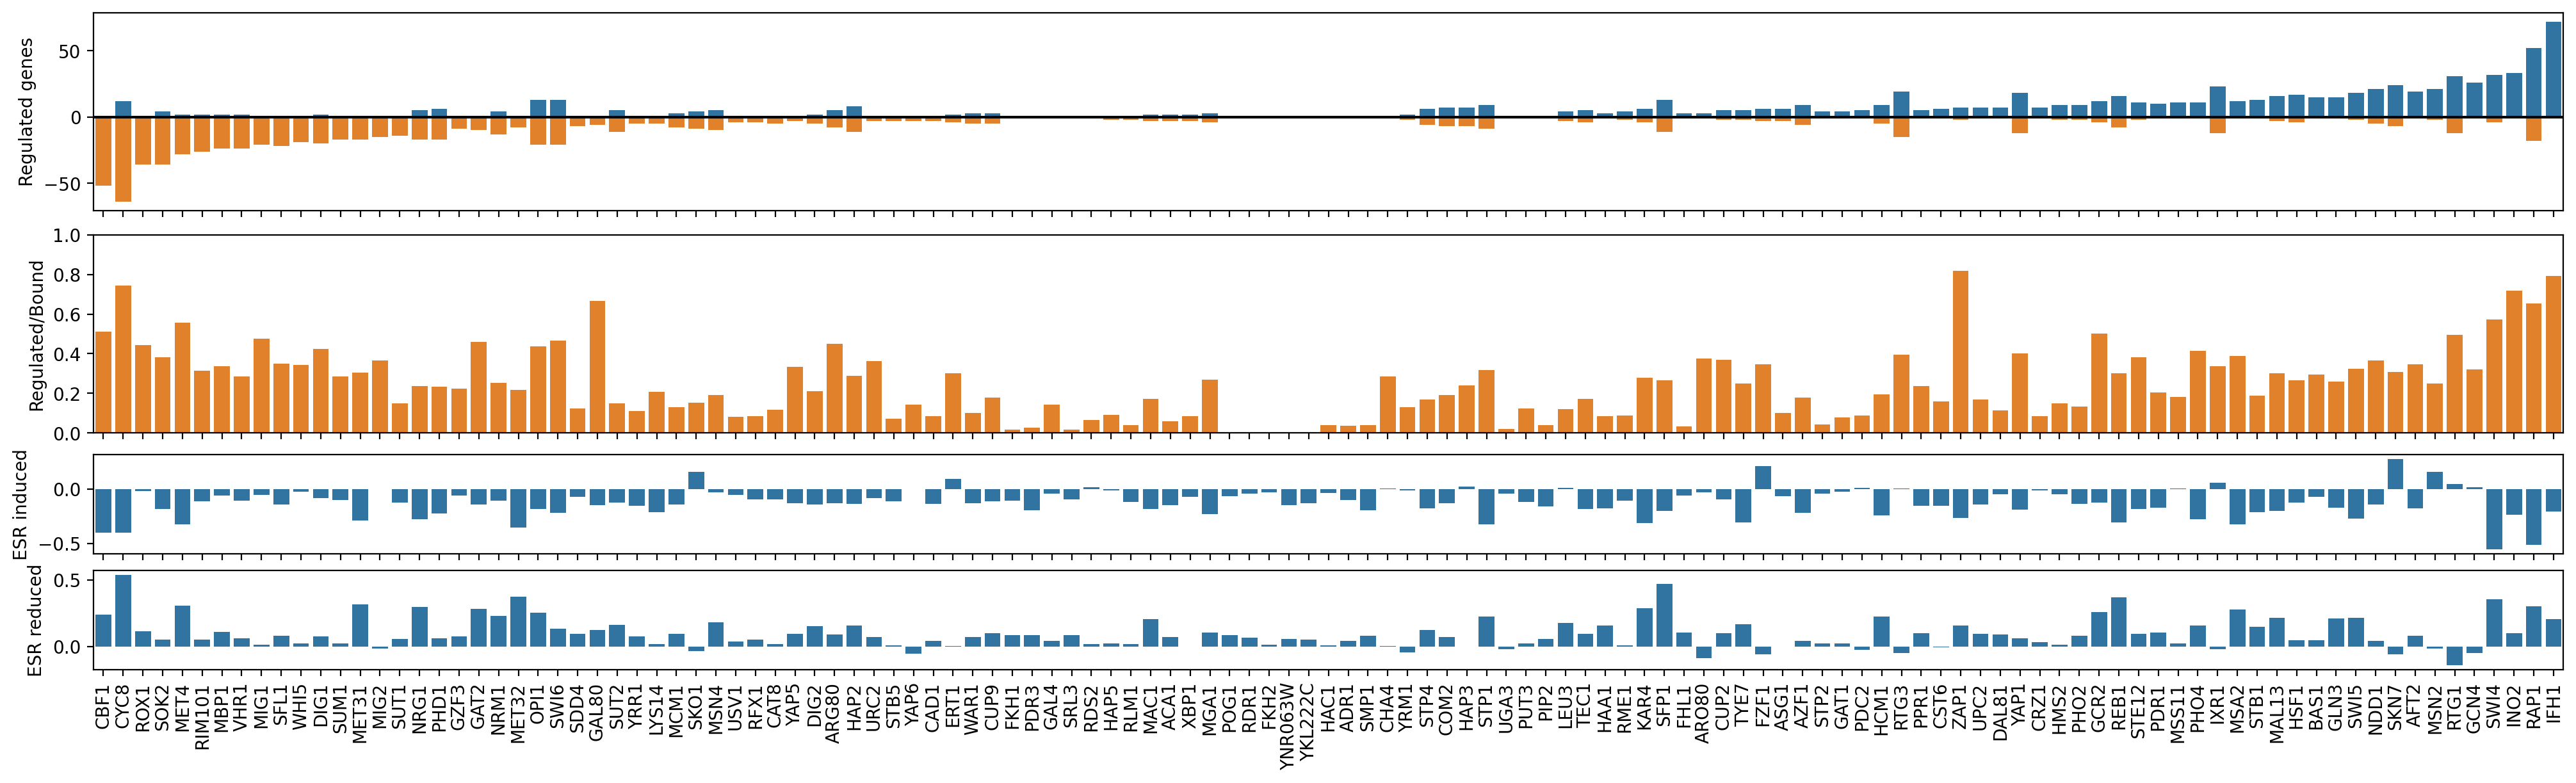

In [98]:
thresh = 3.5
distd = dict()
nums = dict()
for tf in zscored.columns:
    tfd = zscored.loc[expression.index, tf]

    x = tfd[(tfd>=thresh).values]
    medy = expression.loc[:, tf].median()
    y = expression.loc[x.index, tf]
    
    distd[tf] = y[np.abs(y)>=np.log2(1.3)].values
    nums[tf] = y.shape[0]
    
numt = pd.DataFrame(nums, index=['numt']).T

up = (pd.DataFrame({key:pd.Series(value) for key, value in distd.items()})>0).sum().sort_values()
down = -(pd.DataFrame({key:pd.Series(value) for key, value in distd.items()})<0).sum().loc[up.index]
cc = pd.concat([up, down], axis=1)
cc.columns =['UP', 'DOWN']
cc.loc[:, 'SUM'] = cc.sum(axis=1).values
cc = cc.sort_values(by=['SUM', 'UP', 'DOWN'], ascending=(True, True, True))
cc = pd.concat([cc, numt], axis=1)
cc.loc[:, 'TotalReg'] = np.abs(cc.loc[:, ['UP', 'DOWN']]).sum(axis=1)
fig, (ax0,axfrac, ax,ax1) = plt.subplots(4,1, figsize=(20,6), sharex=True, height_ratios = [1,1,.5,.5], constrained_layout=True)

sns.barplot(cc.drop("SUM", axis=1).UP, ax=ax0)
sns.barplot(cc.drop("SUM", axis=1).DOWN, ax=ax0)
ax0.set_ylabel('Regulated genes')
ax0.axhline(0, c='k')


sns.barplot((cc.TotalReg / cc.numt), ax=axfrac)
sns.barplot((cc.TotalReg / cc.numt), ax=axfrac)

axfrac.set_ylim([0,1])
axfrac.set_ylabel('Regulated/Bound')
sns.barplot(expression.loc[stress_genes, cc.index].median().T, ax=ax)
ax.set_ylabel('ESR induced')
sns.barplot(expression.loc[ribo_genes, cc.index].median().T, ax=ax1)
ax1.set_ylabel('ESR reduced')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.show()

fig.savefig('Figures/Func_targets.pdf')